In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# ✅ app/agent/router.py
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState

class Router(TypedDict):
    next: Literal["diet_planer_agent", "exercise_planer_agent", "health_centers_agent", "medication_agent", "symtoms_checker_agent", "air_quality_checker_agent", "FINISH"]

class State(MessagesState):
    next: str

In [3]:
# ✅ app/agent/llm_setup.py
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

load_dotenv()

llm = ChatOpenAI(
    model="gpt-4o-mini", 
    temperature=0.0,
    api_key=os.getenv("OPENAI_API_KEY")
)

In [4]:
import requests
import math
import httpx
from datetime import datetime, timedelta
from langchain_core.tools import tool
from typing import Optional

In [5]:
async def get_geocode_locationiq(place):
    url = "https://us1.locationiq.com/v1/search.php"
    params = {"key": os.getenv("GEOLOCATION_IQ_API_KEY"), "q": place, "format": "json"}
    async with httpx.AsyncClient() as client:
        res = await client.get(url, params=params)
        data = res.json()
        if data:
            return float(data[0]["lat"]), float(data[0]["lon"])
        else:
            return None


async def location_bbox_search(place):
    url = "https://us1.locationiq.com/v1/search.php"
    params = {"key": os.getenv("GEOLOCATION_IQ_API_KEY"), "q": place, "format": "json"}
    async with httpx.AsyncClient() as client:
        res = await client.get(url, params=params)
        data = res.json()
        if data:
            return data
        else:
            return None

In [6]:

@tool
async def get_health_centers(city: str, query: str = "hospitals") -> list:
    """
    Fetches top health centers (e.g., hospitals, clinics) in a city using the Foursquare API
    and returns them as a structured JSON list.

    Parameters:
        city (str): Name of the city (e.g., 'Kolkata')
        query (str): Type of health centers to search for (e.g., hospitals, clinics)

    Returns:
        list: A list of dictionaries, each containing:
            - name: Health center name
            - categories: List of category names
            - address: Formatted address
            - latitude: latitude of the address 
            - longitude: longitude of the address 
            - phone: Telephone number if available
            - website: Website URL if available
    """
    
    api_key = os.getenv("FOURSQUARE_API_KEY")
    
    if not api_key:
        return [{"error": "Missing FOURSQUARE_API_KEY"}]
    url = "https://places-api.foursquare.com/places/search"
    headers = {"accept": "application/json", "X-Places-Api-Version": "2025-06-17", "authorization": api_key}
    params = {"near": city, "query": query, "limit": 10}
    async with httpx.AsyncClient() as client:
        response = await client.get(url, headers=headers, params=params)
        if response.status_code != 200:
            return [{"error": f"Foursquare API error: {response.text}"}]
        results = response.json().get("results", [])
        if not results:
            return [{"message": f"No results found for '{query}' in {city}."}]
        extracted = []
        for place in results:
            address = place['location']['formatted_address']
            lat, lon = await get_geocode_locationiq(address)
            extracted.append({
                "name": place.get("name", "Unknown"),
                "categories": [cat.get("name") for cat in place.get("categories", [])],
                "address": address,
                "latitude": lat,
                "longitude": lon,
                "phone": place.get("tel"),
                "website": place.get("website")
            })
        return extracted
    

@tool
def get_medication_info(ingredient: str) -> dict:
    """
    Retrieves medication label details for a specified active ingredient using the OpenFDA Drug Label API.

    Args:
        ingredient (str): The name of the active ingredient in the medication (e.g., 'paracetamol').

    Returns:
        dict: A dictionary containing key medication details such as usage, warnings, dosage, and ingredients.
            Metadata like disclaimers and API terms are excluded.
            Returns an empty dict if no matching medication is found or if the request fails.
    """
    
    try:
        url = f"https://api.fda.gov/drug/label.json?search=active_ingredient:%22{ingredient}%22&limit=1"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        # Return only the first result if available
        if "results" in data and len(data["results"]) > 0:
            return data["results"][0]
        else:
            return {}
        
    except Exception as e:
        return {"error": str(e)}


@tool
def get_air_quality(zip_code: str) -> dict:
    """
    Fetches current air quality index (AQI) information for a given U.S. ZIP code 
    using the AirNow API.

    Args:
        zip_code (str): A 5-digit U.S. ZIP code (e.g., '90210').

    Returns:
        dict: A dictionary with observed date, area, AQI value, pollutant name, and category.
            Returns an error message if data is unavailable or the request fails.
    """
    
    API_KEY = os.getenv("AIR_QUALITY_API_KEY") 
    url = "https://www.airnowapi.org/aq/observation/zipCode/current/"

    params = {
        "format": "application/json",
        "zipCode": zip_code,
        "distance": 25,
        "API_KEY": API_KEY
    }

    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()

        if not data:
            return {"message": f"No air quality data found for ZIP code {zip_code}."}

        # Return first pollutant's data
        pollutant = data[0]
        return {
            "area": pollutant["ReportingArea"],
            "state": pollutant["StateCode"],
            "latitude": pollutant["Latitude"],
            "longitude": pollutant["Longitude"],
            "pollutant": pollutant["ParameterName"],
            "aqi": pollutant["AQI"],
            "category": pollutant["Category"]["Name"],
            "observed_date": pollutant["DateObserved"],
            "observed_hour": pollutant["HourObserved"],
            "timezone": pollutant["LocalTimeZone"]
        }

    except Exception as e:
        return {"error": str(e)}

In [11]:

# app/agent/agent.py

from typing import Literal
from langgraph.graph import END
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage
# from app.agent.tools import *
# from app.agent.llm_setup import llm
# from app.agent.router import Router, State

async def supervisor(state: State) -> Command[Literal["diet_planer_agent", "exercise_planer_agent", "health_centers_agent", "medication_agent", "symtoms_checker_agent", "air_quality_checker_agent", "__end__"]]:
    """
    The supervisor routes tasks to the appropriate expert agent based on the user's message.
    """
    system_prompt = """
        You are a Supervisor Agent in a health assistant system.

        Your job is to read the user's message and decide which of the following expert agents should handle the request:

        - diet_planer_agent: Creates personalized daily diet plans
        - exercise_planer_agent: Creates personalized exercise plans
        - health_centers_agent: Finds nearby hospitals, clinics, or test centers
        - medication_agent: Provides drug label info for a given ingredient
        - symtoms_checker_agent: Checks symptoms and suggests possible conditions and actions
        - air_quality_checker_agent: Gives air quality details for a ZIP code

        Rules:
        - Choose the agent that best matches the user query
        - Do not guess or hallucinate inputs
        - If the user's request is fully answered, return FINISH

        Respond with one of the following:
        - The exact agent name (e.g., medication_agent)
        - FINISH (if no more action is needed)
        """

    messages = [{"role": "system", "content": system_prompt}] + state["messages"]

    llm_with_structure_output = llm.with_structured_output(Router)
    response = await llm_with_structure_output.ainvoke(messages)

    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})



async def diet_planer_agent(state: State) -> Command[Literal["supervisor"]]:
    agent = create_react_agent(
        llm,
        tools=[],
        prompt="""
            You are a personalized diet planning expert focused on creating healthy, balanced, and goal-oriented meal plans.

            Your goal is to generate a **complete daily diet plan** in HTML format based on the user's profile, preferences, health conditions, and goals (e.g., weight loss, diabetes-friendly, vegetarian, high-protein, etc.).

            Use the following structure and return the response wrapped in a `<div class="diet-plan">` block containing:

            <h2>Personalized Diet Plan</h2>

            <ul>
            <li><strong>Goal:</strong> [Weight loss / Gain / Diabetes-friendly / etc.]</li>
            <li><strong>Total Calories:</strong> [1200 kcal / 1500 kcal / etc.]</li>
            </ul>

            <h3>Breakfast</h3>
            <ul>
            <li><strong>Time:</strong> 8:00 AM</li>
            <li><strong>Items:</strong> Oats porridge with nuts, 1 boiled egg, 1 apple</li>
            <li><strong>Calories:</strong> 350 kcal</li>
            </ul>

            <h3>Mid-Morning Snack</h3>
            <ul>
            <li><strong>Time:</strong> 10:30 AM</li>
            <li><strong>Items:</strong> Buttermilk or fruit salad</li>
            <li><strong>Calories:</strong> 100 kcal</li>
            </ul>

            <h3>Lunch</h3>
            <ul>
            <li><strong>Time:</strong> 1:00 PM</li>
            <li><strong>Items:</strong> 1 cup white rice, dal, mixed veg curry, salad</li>
            <li><strong>Calories:</strong> 400 kcal</li>
            </ul>

            <h3>Evening Snack</h3>
            <ul>
            <li><strong>Time:</strong> 4:30 PM</li>
            <li><strong>Items:</strong> Roasted chana or sprouts, green tea</li>
            <li><strong>Calories:</strong> 150 kcal</li>
            </ul>

            <h3>Dinner</h3>
            <ul>
            <li><strong>Time:</strong> 7:30 PM</li>
            <li><strong>Items:</strong> Grilled chicken or paneer, sautéed veggies</li>
            <li><strong>Calories:</strong> 400 kcal</li>
            </ul>

            <h3>Notes</h3>
            <ul>
            <li>Drink at least 2.5L of water daily</li>
            <li>Avoid sugary snacks and refined flour</li>
            <li>Include 1 hour of walking or moderate exercise</li>
            </ul>

            Do not include markdown or plaintext — **only valid HTML** using the above format.

            Customize the meals and notes depending on health goals, dietary preference (veg/non-veg), and special needs (e.g., diabetic, hypothyroid, gluten-free).
        """
    )

    result = await agent.ainvoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="diet_planer_agent")
            ]
        },
        goto="supervisor"
    )


async def exercise_planer_agent(state: State) -> Command[Literal["supervisor"]]:
    agent = create_react_agent(
        llm,
        tools=[],  # no tools; collaborate via prior agent outputs in the conversation
        prompt="""
            You are an exercise planning expert. Create a safe, goal-oriented daily exercise plan that collaborates with other agents' outputs if available (diet_planer_agent, symtoms_checker_agent, medication_agent, air_quality_checker_agent, health_centers_agent).

            Rules:
            - Read the latest conversation. If prior HTML from other agents is present, align the exercise plan with:
            - Diet goals and timing (from diet_planer_agent)
            - Symptom flags & cautions (from symtoms_checker_agent)
            - Medication timing or warnings (from medication_agent)
            - AQI category and pollutant (from air_quality_checker_agent) — reduce outdoor intensity if AQI is not "Good"
            - Nearby facility constraints (from health_centers_agent), if relevant
            - Respect user constraints (e.g., beginner, injuries, “walking only”, diabetes, hypertension).
            - Keep it practical, time-bound, and safe.
            - Output **only valid HTML** using the structure below. No markdown, no JSON.

            Wrap the response in:
            <div class="exercise-plan"> ... </div>

            Use this HTML structure:

            <div class="exercise-plan">
            <h2>Personalized Exercise Plan</h2>

            <ul>
                <li><strong>Goal:</strong> [e.g., Weight loss / Cardiovascular fitness / Mobility]</li>
                <li><strong>Fitness Level:</strong> [Beginner / Intermediate / Advanced]</li>
                <li><strong>Constraints:</strong> [e.g., Walking-only, knee pain, diabetes, hypertension]</li>
            </ul>

            <h3>Daily Session</h3>
            <ul>
                <li><strong>Warm-up (5–10 min):</strong> [e.g., brisk walk, joint circles]</li>
                <li><strong>Main Activity (20–45 min):</strong> [e.g., walking intervals / cycling / bodyweight circuit]</li>
                <li><strong>Cool-down (5–10 min):</strong> [slow walk + stretches]</li>
                <li><strong>Intensity:</strong> [RPE 4–6 / talk test able to speak in phrases]</li>
            </ul>

            <h3>Weekly Outline</h3>
            <ul>
                <li><strong>Mon:</strong> [Session type & duration]</li>
                <li><strong>Tue:</strong> [Session type & duration]</li>
                <li><strong>Wed:</strong> [Session type & duration]</li>
                <li><strong>Thu:</strong> [Session type & duration]</li>
                <li><strong>Fri:</strong> [Session type & duration]</li>
                <li><strong>Sat:</strong> [Session type & duration]</li>
                <li><strong>Sun:</strong> [Active rest / mobility]</li>
            </ul>

            <h3>Coordination with Diet</h3>
            <ul>
                <li><strong>Pre-workout:</strong> [light snack timing aligned with breakfast/lunch]</li>
                <li><strong>Post-workout:</strong> [protein + carbs window]</li>
                <li><strong>Hydration:</strong> [daily target]</li>
            </ul>

            <h3>Safety & Adjustments</h3>
            <ul>
                <li>If experiencing warning symptoms, reduce intensity and consult a professional.</li>
                <li>If AQI is not "Good", prefer indoor or low-intensity options.</li>
                <li>Space workouts away from medications that advise avoiding exertion.</li>
            </ul>

            <p><em>Note:</em> This plan is educational and not a medical diagnosis. Adjust based on professional advice.</p>
            </div>
        """
    )

    result = await agent.ainvoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="exercise_planer_agent")
            ]
        },
        goto="supervisor"
    )



async def health_centers_agent(state: State) -> Command[Literal["supervisor"]]:
    agent = create_react_agent(
            llm,
            tools=[get_health_centers],
            prompt="""
                You are an expert in finding health centers like hospitals, clinics, blood test centers etc.

                Use the get_health_centers tool to return the top 5 health centers.

                For each result, include:
                - Name
                - Category (hospitals, clinics etc)
                - Address
                - Latitude and Longitude (always include)
                - Phone (if available)
                - Website (as a clickable link)
                
                `latitude` and `longitude` must always be included.
                Return the output in clean HTML format using <ul>/<li> or <div>. No JSON or plain text. Keep it structured and readable.
        """
    )
    result = await agent.ainvoke(state)
    return Command(update={"messages": [HumanMessage(content=result["messages"][-1].content, name="health_centers_agent")]}, goto="supervisor")


async def medication_agent(state: State) -> Command[Literal["supervisor"]]:
    agent = create_react_agent(
        llm,
        tools=[get_medication_info],
        prompt="""
            You are a medication information expert. Use the `get_medication_info` tool to retrieve drug label information 
            from the OpenFDA Drug Label API for a given active ingredient.

            Once you receive the tool response, extract the following fields (if available) and format them in clear, structured HTML:

            - <strong>Active Ingredient</strong>
            - <strong>Purpose</strong>
            - <strong>Indications and Usage</strong>
            - <strong>Dosage and Administration</strong>
            - <strong>Warnings</strong>
            - <strong>Inactive Ingredients</strong>
            - <strong>Storage and Handling</strong>
            - <strong>Contact Information (Questions)</strong>

            Structure the output using proper <div>, <ul>, and <li> tags as follows:

            <div class="medication-info">
            <h2>Medication Information for: <em>{ingredient}</em></h2>

            <ul>
                <li><strong>Active Ingredient:</strong> {active_ingredient}</li>
                <li><strong>Purpose:</strong> {purpose}</li>
                <li><strong>Usage:</strong> {indications_and_usage}</li>
                <li><strong>Dosage:</strong> {dosage_and_administration}</li>
                <li><strong>Warnings:</strong> {warnings}</li>
                <li><strong>Inactive Ingredients:</strong> {inactive_ingredient}</li>
                <li><strong>Storage Info:</strong> {storage_and_handling}</li>
                <li><strong>Questions or Contact:</strong> {questions}</li>
            </ul>
            </div>

            Do not include: raw JSON, metadata like `set_id`, `effective_time`, or empty sections.
            If a field is missing in the response, skip it gracefully.
            Respond only in valid and styled HTML.
        """
    )

    result = await agent.ainvoke(state)

    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="medication_agent")]},
        goto="supervisor"
    )
    


async def symtoms_checker_agent(state: State) -> Command[Literal["supervisor"]]:
    agent = create_react_agent(
        llm,
        tools=[],
        prompt="""
            You are an experienced medical assistant that helps users understand their symptoms and potential conditions.

            Your job is to analyze the user's symptoms and provide a structured and informative response that includes:

            - Possible health conditions or illnesses based on the symptoms
            - Recommended next steps (e.g., home remedies, doctor consultation, tests)
            - Urgency level
            - When to seek emergency help

            You should:
            - NOT diagnose
            - NOT suggest medications
            - Always encourage professional medical advice

            Return the response **strictly in HTML** inside a `<div class="symptoms-checker">` container using this format:

            <div class="symptoms-checker">
            <h2>Symptom Checker Results</h2>

            <ul>
                <li><strong>Reported Symptoms:</strong> {comma-separated symptoms}</li>
                <li><strong>Possible Conditions:</strong>
                <ul>
                    <li>Condition 1 - short explanation</li>
                    <li>Condition 2 - short explanation</li>
                </ul>
                </li>
                <li><strong>Urgency:</strong> Low / Moderate / High</li>
                <li><strong>Recommended Actions:</strong>
                <ul>
                    <li>Stay hydrated and rest</li>
                    <li>Monitor temperature every 4 hours</li>
                    <li>Consult a doctor if symptoms persist beyond 48 hours</li>
                </ul>
                </li>
                <li><strong>When to Seek Emergency Help:</strong> {clear warning signs}</li>
            </ul>

            <h3>Disclaimer</h3>
            <p>This information is for educational purposes only and does not replace professional medical advice.</p>
            </div>

            Notes:
            - Format using only <div>, <ul>, <li>, and <p> tags. No markdown or plaintext.
            - Skip missing fields gracefully.
            - Be concise, helpful, and medically responsible.
        """
    )

    result = await agent.ainvoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="symtoms_checker_agent")
            ]
        },
        goto="supervisor"
    )


async def air_quality_checker_agent(state: State) -> Command[Literal["supervisor"]]:
    agent = create_react_agent(
        llm,
        tools=[get_air_quality],
        prompt="""
            You are an air quality monitoring assistant.

            Use the `get_air_quality` tool to retrieve the current Air Quality Index (AQI) for the specified U.S. ZIP code.

            Once you receive the data, display the following fields in a clean and user-friendly HTML block:

            - Reporting Area (e.g., NW Coastal LA)
            - State
            - Latitude and Longitude
            - Pollutant (e.g., O3, PM2.5)
            - AQI Value
            - AQI Category (e.g., Good, Moderate, Unhealthy)
            - Observed Date
            - Observed Hour (24-hr format)
            - Timezone

            Wrap the full output in:
            <div class="air-quality-info">...</div>

            Use the following HTML structure:

            <div class="air-quality-info">
            <h2>Current Air Quality Report</h2>
            <ul>
                <li><strong>Area:</strong> {area}</li>
                <li><strong>State:</strong> {state}</li>
                <li><strong>Latitude:</strong> {latitude}</li>
                <li><strong>Longitude:</strong> {longitude}</li>
                <li><strong>Pollutant:</strong> {pollutant}</li>
                <li><strong>AQI:</strong> {aqi}</li>
                <li><strong>Category:</strong> {category}</li>
                <li><strong>Observed Date:</strong> {observed_date}</li>
                <li><strong>Observed Hour:</strong> {observed_hour} {timezone}</li>
            </ul>
            <p>Values based on data from AirNow API. Always refer to local authorities for health precautions.</p>
            </div>

            Do not include raw JSON, plain text, or undefined fields. Format everything using only <div>, <ul>, <li>, <p>, <strong>, and <h2>.

            Respond only with valid HTML.
        """
    )

    result = await agent.ainvoke(state)

    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="air_quality_checker_agent")]},
        goto="supervisor"
    )

In [22]:
# response = get_air_quality.invoke(
#     {'zip_code': '90210'}
# )
# response

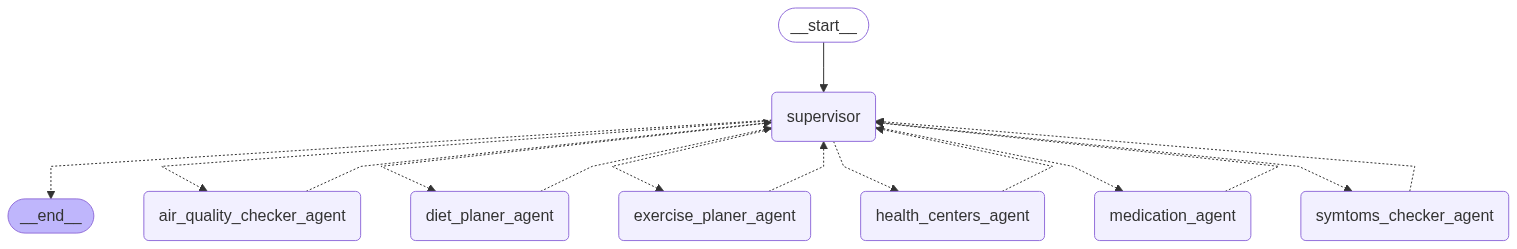

In [12]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
# from app.agent.router import State
# from app.agent.agent import *  # Make sure this includes all agent functions and `State`

graph = StateGraph(State)

# Add nodes for all agents
graph.add_node("supervisor", supervisor)
graph.add_node("diet_planer_agent", diet_planer_agent)
graph.add_node("exercise_planer_agent", exercise_planer_agent)
graph.add_node("health_centers_agent", health_centers_agent)
graph.add_node("medication_agent", medication_agent)
graph.add_node("symtoms_checker_agent", symtoms_checker_agent)
graph.add_node("air_quality_checker_agent", air_quality_checker_agent)

# Define graph edges
graph.add_edge(START, "supervisor")
graph.add_edge("diet_planer_agent", "supervisor")
graph.add_edge("exercise_planer_agent", "supervisor")
graph.add_edge("health_centers_agent", "supervisor")
graph.add_edge("medication_agent", "supervisor")
graph.add_edge("symtoms_checker_agent", "supervisor")
graph.add_edge("air_quality_checker_agent", "supervisor")
graph.add_edge("supervisor", END)

# Set up memory and compile the app
memory = MemorySaver()
app = graph.compile()
app